# Create SparkSession, import packages

### To update git hub
### git add *
### git commit -m "Insert you change message"
### git push origin master

# To Do:
* combine the data with the features file, to get a header
* do variable selection and transformation
* spit out a final `.csv` to use for modeling

# Ideas
* look at the data via kmeans with 6 clusters?
* compute AUC on each variable to see which are important? (after regressing on the var)
* create variables that are combinations of other variables
* look for outliers and then run pca before clustering?
* run multinomial regression with elastic net? (with k-fold cv)
* or maybe try neural nets?
* something time series?


In [1]:
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.types as typ
import pyspark.sql.functions as F
import os
import pandas as pd
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

In [2]:
#read in with pandas first since the data is weirdly delimited
pandas_train_features = pd.read_csv("Data/X_train.txt", sep='\s+',header=None)
#conversion to spark df
df_train_features = sqlCtx.createDataFrame(pandas_train_features)

In [3]:
#training labels
pandas_train_labels = pd.read_csv("Data/y_train.txt", sep='\s+',header=None)
#conversion to spark df
df_train_labels = sqlCtx.createDataFrame(pandas_train_labels)

In [4]:
#test features
pandas_test_features = pd.read_csv("Data/X_test.txt", sep='\s+',header=None)
#conversion to spark df
df_test_features = sqlCtx.createDataFrame(pandas_test_features)

In [5]:
#test labels
pandas_test_labels = pd.read_csv("Data/y_test.txt", sep='\s+',header=None)
#conversion to spark df
df_test_labels = sqlCtx.createDataFrame(pandas_test_labels)

In [6]:
#header
pandas_header = pd.read_csv("Data/features.txt", sep='\s+',header=None)
#conversion to spark df. this has an index column, so we deselect it
df_header = sqlCtx.createDataFrame(pandas_header)


In [7]:
#reading subject number in
panda_sub_train=pd.read_csv("Data/subject_train.txt",sep='\s+',header=None)
panda_sub_train.columns=['id']
panda_sub_test=pd.read_csv("Data/subject_test.txt",sep='\s+',header=None)
panda_sub_test.columns=['id']
df_sub_train=sqlCtx.createDataFrame(panda_sub_train)
df_sub_test=sqlCtx.createDataFrame(panda_sub_test)

In [8]:
#merge x feature files with subject id
merged_train=pd.merge(panda_sub_train,pandas_train_features, right_index=True, left_index=True)
merged_test=pd.merge(panda_sub_test,pandas_test_features, right_index=True, left_index=True)
df_merged_train_features=sqlCtx.createDataFrame(merged_train)
df_merged_ttest_features=sqlCtx.createDataFrame(merged_test)

In [9]:
#reading in y responses for training
pandas_y_train = pd.read_csv("Data/y_train.txt",header=None)
df_y_train = sqlCtx.createDataFrame(pandas_y_train)


#reading in y responses for test
pandas_y_test = pd.read_csv("Data/y_test.txt",header=None)
df_y_test = sqlCtx.createDataFrame(pandas_y_test)              #Kevin


In [10]:
df_merged_train_features.show()

+---+----------+--------------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+-----------+-----------+------------+------------+--------------------+--------------------+--------------------+--------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+-----------+--------------------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+--------------------+----------+-----------+--------------------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+----+-----------+------------+-----------+--------------------+-------------------+-----------+-----------+---------

In [11]:
#check for missing values
from pyspark.sql.functions import isnan, when, count, col
df_merged_train_features.select([count(when(isnan(c), c)).alias(c) for c in df_merged_train_features.columns]).show()


+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---

In [12]:
df_merged_train_features.select('0','1','2','3','4').describe().show()

+-------+-------------------+--------------------+--------------------+-------------------+-------------------+
|summary|                  0|                   1|                   2|                  3|                  4|
+-------+-------------------+--------------------+--------------------+-------------------+-------------------+
|  count|               7352|                7352|                7352|               7352|               7352|
|   mean| 0.2744881249635204|-0.01769542735779...|-0.10914102015124041|-0.6054384511368359|-0.5109375609608321|
| stddev|0.07026133266614942|0.040810524573263465|  0.0566351880847293| 0.4487343844696271| 0.5026446547401445|
|    min|               -1.0|                -1.0|                -1.0|               -1.0|        -0.99987292|
|    max|                1.0|                 1.0|                 1.0|                1.0|         0.91623796|
+-------+-------------------+--------------------+--------------------+-------------------+-------------

In [13]:
df_merged_train_features.select('0','1','2','3','4').describe().show()

+-------+-------------------+--------------------+--------------------+-------------------+-------------------+
|summary|                  0|                   1|                   2|                  3|                  4|
+-------+-------------------+--------------------+--------------------+-------------------+-------------------+
|  count|               7352|                7352|                7352|               7352|               7352|
|   mean| 0.2744881249635204|-0.01769542735779...|-0.10914102015124041|-0.6054384511368359|-0.5109375609608321|
| stddev|0.07026133266614942|0.040810524573263465|  0.0566351880847293| 0.4487343844696271| 0.5026446547401445|
|    min|               -1.0|                -1.0|                -1.0|               -1.0|        -0.99987292|
|    max|                1.0|                 1.0|                 1.0|                1.0|         0.91623796|
+-------+-------------------+--------------------+--------------------+-------------------+-------------

In [14]:
ds = pd.DataFrame(index=[1], columns=['train_features_obs','train_labels_obs','test_features_obs','test_labels_obs', 'header_obs'])
ds['train_features_obs'] = df_train_features.count()
ds['train_labels_obs'] = df_train_labels.count()
ds['test_features_obs'] = df_test_features.count()
ds['test_labels_obs'] = df_test_labels.count()
ds['header_obs']= df_header.count()
ds=sqlCtx.createDataFrame(ds)
ds.show()                #created data frame to show how many obs in each file
                        #makes it easier to see under df, -Kevin



+------------------+----------------+-----------------+---------------+----------+
|train_features_obs|train_labels_obs|test_features_obs|test_labels_obs|header_obs|
+------------------+----------------+-----------------+---------------+----------+
|              7352|            7352|             2947|           2947|       561|
+------------------+----------------+-----------------+---------------+----------+



In [15]:
split_col = F.split(df_header['1'], '-')
df_header = df_header.withColumn('Main', split_col.getItem(0))
df_header = df_header.withColumn('Seconded', split_col.getItem(1)) #Kevin

In [16]:
df_header.show()

+---+-------------------+--------+--------+
|  0|                  1|    Main|Seconded|
+---+-------------------+--------+--------+
|  1|  tBodyAcc-mean()-X|tBodyAcc|  mean()|
|  2|  tBodyAcc-mean()-Y|tBodyAcc|  mean()|
|  3|  tBodyAcc-mean()-Z|tBodyAcc|  mean()|
|  4|   tBodyAcc-std()-X|tBodyAcc|   std()|
|  5|   tBodyAcc-std()-Y|tBodyAcc|   std()|
|  6|   tBodyAcc-std()-Z|tBodyAcc|   std()|
|  7|   tBodyAcc-mad()-X|tBodyAcc|   mad()|
|  8|   tBodyAcc-mad()-Y|tBodyAcc|   mad()|
|  9|   tBodyAcc-mad()-Z|tBodyAcc|   mad()|
| 10|   tBodyAcc-max()-X|tBodyAcc|   max()|
| 11|   tBodyAcc-max()-Y|tBodyAcc|   max()|
| 12|   tBodyAcc-max()-Z|tBodyAcc|   max()|
| 13|   tBodyAcc-min()-X|tBodyAcc|   min()|
| 14|   tBodyAcc-min()-Y|tBodyAcc|   min()|
| 15|   tBodyAcc-min()-Z|tBodyAcc|   min()|
| 16|     tBodyAcc-sma()|tBodyAcc|   sma()|
| 17|tBodyAcc-energy()-X|tBodyAcc|energy()|
| 18|tBodyAcc-energy()-Y|tBodyAcc|energy()|
| 19|tBodyAcc-energy()-Z|tBodyAcc|energy()|
| 20|   tBodyAcc-iqr()-X|tBodyAc

In [17]:
header_summary=df_header.groupBy('Main').count()
header_summary.count()                               #Kevin
              

24

In [18]:
header_summary.orderBy('count',ascending = False).show()      #Kevin

+--------------------+-----+
|                Main|count|
+--------------------+-----+
|        fBodyAccJerk|   79|
|           fBodyGyro|   79|
|            fBodyAcc|   79|
|        tBodyAccJerk|   40|
|         tGravityAcc|   40|
|           tBodyGyro|   40|
|       tBodyGyroJerk|   40|
|            tBodyAcc|   40|
|         fBodyAccMag|   13|
|    tBodyGyroJerkMag|   13|
|fBodyBodyGyroJerkMag|   13|
|        tBodyGyroMag|   13|
|    fBodyBodyGyroMag|   13|
|         tBodyAccMag|   13|
|      tGravityAccMag|   13|
| fBodyBodyAccJerkMag|   13|
|     tBodyAccJerkMag|   13|
|angle(X,gravityMean)|    1|
|angle(tBodyGyroJe...|    1|
|angle(Y,gravityMean)|    1|
+--------------------+-----+
only showing top 20 rows



In [19]:
header_summary.groupBy("Main").count().rdd.values().histogram(20)   #Kevin

([1, 1], [24])

In [20]:
header_barplot= df_header.toPandas()                    # converted to pandas since easier, RDD tricky
header_barplot['Main'].value_counts().plot(kind='bar')  #Visualize Main Variable count
                                                        #Kevin

In [21]:
#visualizing subject activity count 

In [22]:
y_train_summary=df_y_train.groupBy('0').count()       #0 is column name
y_train_summary.count()     # total activities                                                  #kevin

6

In [23]:
y_train_summary.show()

+---+-----+
|  0|count|
+---+-----+
|  6| 1407|
|  5| 1374|
|  1| 1226|
|  3|  986|
|  2| 1073|
|  4| 1286|
+---+-----+



In [24]:
y_train_summary.orderBy('count', ascending=False).show()     #ordered
                                                            #kevin

+---+-----+
|  0|count|
+---+-----+
|  6| 1407|
|  5| 1374|
|  4| 1286|
|  1| 1226|
|  2| 1073|
|  3|  986|
+---+-----+



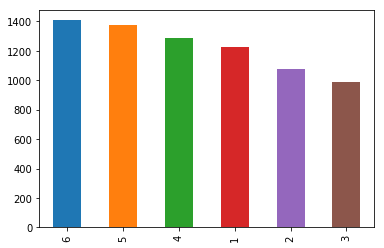

In [25]:
y_train_barplot= df_y_train.toPandas()                    # converted to pandas since easier, RDD tricky
y_train_barplot['0'].value_counts().plot(kind='bar')      #maybe nicer if we change x axis to display activity label?

In [26]:
y_test_summary=df_y_test.groupBy('0').count()       #0 is column name
y_test_summary.count()     # total activities 

6

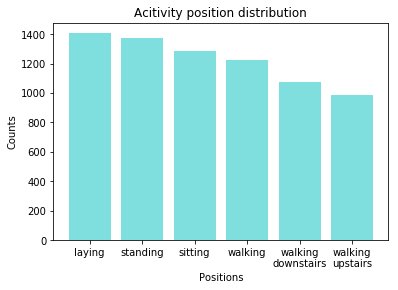

In [27]:
import matplotlib.pyplot
y_train_bar=y_train_barplot['0'].value_counts() #data read
increment=[1,2,3,4,5,6]
names=['laying','standing','sitting','walking','walking\ndownstairs','walking\nupstairs']
matplotlib.pyplot.bar(increment, y_train_bar, align='center', alpha=0.5, color='c') #Barplot
matplotlib.pyplot.xticks(increment,names)
matplotlib.pyplot.ylabel('Counts')
matplotlib.pyplot.xlabel('Positions')
matplotlib.pyplot.title('Acitivity position distribution')
matplotlib.pyplot.show()

#how are the positiosn distributed?

In [28]:
y_test_summary.show()

+---+-----+
|  0|count|
+---+-----+
|  6|  537|
|  5|  532|
|  1|  496|
|  3|  420|
|  2|  471|
|  4|  491|
+---+-----+



In [29]:
y_test_summary.orderBy('count', ascending=False).show()      #ordered from biggest to smallest
                                                            # kevin

+---+-----+
|  0|count|
+---+-----+
|  6|  537|
|  5|  532|
|  1|  496|
|  4|  491|
|  2|  471|
|  3|  420|
+---+-----+



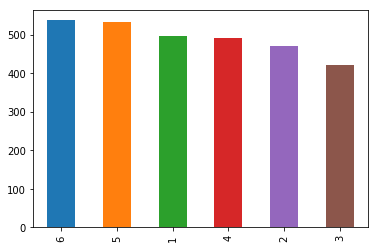

In [34]:
y_test_barplot= df_y_test.toPandas()                    # converted to pandas since easier, RDD tricky
y_test_barplot['0'].value_counts().plot(kind='bar')     #Kevin
Y_test_bar=y_test_barplot['0'].value_counts()

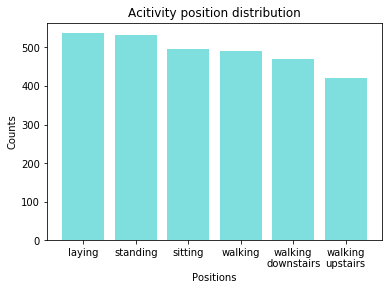

In [36]:
increment=[1,2,3,4,5,6]
names=['laying','standing','sitting','walking','walking\ndownstairs','walking\nupstairs']
matplotlib.pyplot.bar(increment, Y_test_bar, align='center', alpha=0.5, color='c') #Barplot
matplotlib.pyplot.xticks(increment,names)
matplotlib.pyplot.ylabel('Counts')
matplotlib.pyplot.xlabel('Positions')
matplotlib.pyplot.title('Acitivity position distribution')
matplotlib.pyplot.show()

# Separable Activities - (NEW)

In [ ]:
#assume df is combined activities



# Outlier Detection, Using Interquartile Range Method

In [31]:
cols = [c for c in df_train_features.columns]   # exclude id from features
bounds = {} # will store lower and upper bounds for each feature              #Will use later, -Kevin

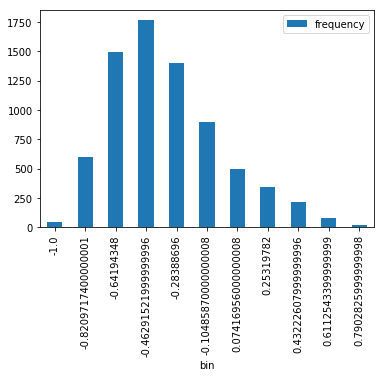

In [32]:
import pyspark.sql as sparksql
histogram = df_train_features.select('539').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

#539 is fBodyBodyGyroMag-meanFreq()
#histogram for distributiono of a variable
#kevin- uhh kind of junk rn but may be usefull later


# Look at class imbalance in our data